# Corpus and BGRF Composition

We describe and analyse the status quo of the corpus with respect to criteria like author gender, year of first publication, narrative form etc. Then we compare it to the "baseline" of the BGRF.

**Table of Contents**
* [Prerequisites](#Prerequisites)
* [Corpus Metadata](#Corpus-Metadata)
  - [Author Gender](#Author-Gender)
  - [Text Length](#Text-Length)
  - [Publication Date](#Year-of-first-publication)
  - [Narrative Form](#Narrative-Form)
* [BGRF Metadata from Wikibase](#BGRF-Metadata-from-Wikibase)
  - [Configuration](#Configuration)
  - [Data Loading](#Data-Loading)
  - [Author Gender](#Author-Gender-(BGRF))
  - [Text Length](#Text-Length-(BGRF))
  - [Publication Date](#Publication-Date-(BGRF))
  - [Narrative Form](#Narrative-Form-(BGRF))
* [Comparison](#Comparison)
  - [Publication Date](#Publication-Date-(Corpus-vs-BGRF))
  

## Prerequisites

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

# Install with e.g. `pip install sparqlwrapper`
from SPARQLWrapper import SPARQLWrapper, JSON

# Make plots appear directly in the notebook.
%matplotlib inline

from pprint import pprint

The later parts also require access to a Wikibase instance, which is only accessible in/over the university network.

## Corpus Metadata

In [40]:
# Adjust the URL to the .tsv file as needed.
DATA_URL = 'https://raw.githubusercontent.com/MiMoText/roman18/master/XML-TEI/xml-tei_metadata.tsv'
corpus = pd.read_csv(DATA_URL, sep='\t')
print('Available column names:', corpus.columns.values)

Available column names: ['filename' 'au-name' 'title' 'au-gender' 'firsted-yr' 'printSource-yr'
 'form' 'spelling' 'data-capture' 'token count' 'size' 'bgrf']


### Author Gender

Data is in the column 'au-gender'. Possible values are 'F', 'M' and 'U'.

Set of all occuring values: {'M', 'F', 'U'}
% of female authors: 	0.184
% of male authors: 	0.789
% of unknown/other: 	0.026


Text(0, 0.5, 'Count in corpus')

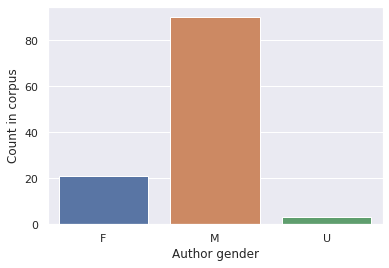

In [17]:
gender = corpus['au-gender'].astype('category')
print('Set of all occuring values:', set(gender.values))
ratio_female = (gender == 'F').sum() / gender.count()
ratio_male = (gender == 'M').sum() / gender.count()
ratio_other = 1 - ratio_female - ratio_male
print(
    f'% of female authors: \t{ratio_female:.3f}\n'
    f'% of male authors: \t{ratio_male:.3f}\n'
    f'% of unknown/other: \t{ratio_other:.3f}'
)
sns.countplot(x=gender)
plt.xlabel('Author gender')
plt.ylabel('Count in corpus')

### Text Length
Data is in the column 'size', possible values are 'short', 'medium', 'long'.

% of short texts: 	0.491
% of medium texts: 	0.289
% of long texts: 	0.219


Text(0, 0.5, 'Count in corpus')

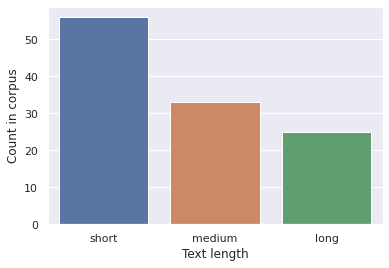

In [18]:
size = corpus['size']
ratio_size_short = (size == 'short').sum() / size.count()
ratio_size_med = (size == 'medium').sum() / size.count()
ratio_size_long = (size == 'long').sum() / size.count()
print(
    f'% of short texts: \t{ratio_size_short:.3f}\n'
    f'% of medium texts: \t{ratio_size_med:.3f}\n'
    f'% of long texts: \t{ratio_size_long:.3f}'
)
sns.countplot(x=size)
plt.xlabel('Text length')
plt.ylabel('Count in corpus')

### Year of first publication
Data is in the column 'firsted-yr'. However, possible values can be single years `(yyyy)`, year spans `(yyyy-yyyy)`, the floating point number value `NaN`, or even a string like `'unknown'`. Therefore, we need to clean up a bit before we can use it. In case of year ranges, we simply use the first year.

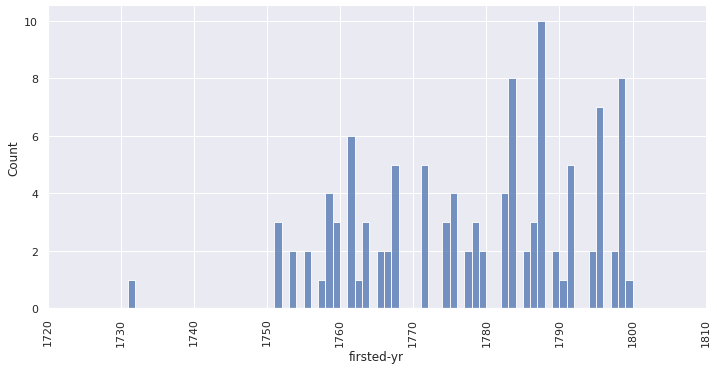

In [19]:
pubyear = (corpus['firsted-yr']
    .astype('|S')
    .replace('(\d{4})-\d{4}', '\1', regex=True)
    .str.decode('utf-8'))
pubyear = pd.to_datetime(pubyear, errors='coerce')

#pubyear = pd.to_numeric(pubyear, errors='coerce').astype('Int64')
time_range = pubyear.max().year - pubyear.min().year
plot = sns.displot(x=pubyear, bins=time_range, height=5, aspect=16/8)
plot.set_xticklabels(rotation=90)

### Narrative form
Data is in the column 'form'. Possible values include `'mixed'`, `'autodiegetic'`, `'heterodiegetic'`, `'homodiegetic'`, `'epistolary'`, `'dialogue novel'` and also `NaN`.

Set of all values:  {'homodiegetic', nan, 'mixed', 'heterodiegetic', 'epistolary', 'dialogue novel', 'autodiegetic'}
% of mixed: 	0.036
% of autodiegetic: 	0.250
% of heterodiegetic: 	0.348
% of homodiegetic: 	0.036
% of epistolary: 	0.268
% of dialogue novel: 	0.062


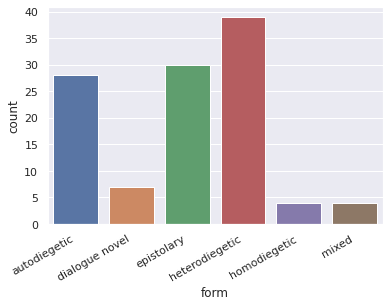

In [20]:
form = corpus['form'].astype('category')
print('Set of all values: ', set(form.values))
print('\n'.join([
    f'% of {kind}: \t{((form==kind).sum()/form.count()):.3f}'
    for kind in [
        'mixed', 'autodiegetic', 'heterodiegetic', 'homodiegetic',
        'epistolary', 'dialogue novel'
    ]
]))
plot = sns.countplot(x=form)
_ = plt.xticks(rotation=30, horizontalalignment='right')

## BGRF Metadata from Wikibase
Data is pulled from Wikibase. For the moment, our instance on port 53100 is used. This may change in the future, which then will not only affect the URL but also the IDs of the items and predicates. Adjust these accordingly in the [Configuration Section](#Configuration).

### Configuration

In [21]:
# Adjust these values whenever another Wikibase instance is to be used.
WB_URL = 'http://zora.uni-trier.de:53100'
ITEM_IDS = {
    'publication_date': 'P7',
    'publication_date_str': 'P43',  # hard to use, since not normalized
    'sex_or_gender': 'P29',         # currently no data on :53100
    'narrative_form': 'P55',        # currently no data on :53100
    'narrative_form_str': 'P47',
    'page_count': 'P35',            # currently no data on :53100
    'page_count_str': 'P45',
    'distribution_format_str': 'P46',
    'distribution_format': 'P38',   # currently no data on :53100
}

### Data Loading

We use the SPARQL endpoint to query the bibliography metadata. Each metadatum gets its own query for simplicity's sake.

In [22]:
bgrf = pd.DataFrame()
wb_endpoint = f'{WB_URL}/proxy/wdqs/bigdata/namespace/wdq/sparql'

def get_data(endpoint, query):
    '''Given an endpoint URL and a SPARQL query, return
    the data as JSON.
    '''
    user_agent = 'jupyter notebook'
    sparql = SPARQLWrapper(endpoint, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()["results"]["bindings"]

This wrapper function conveniently provides the data as python dictionaries.
For example, to get all the data values for the property `narrative_form_str`,
we can use the following:

In [23]:
ex_query = 'SELECT DISTINCT ?form WHERE { ?item wdt:P46 ?form. }'
results = get_data(wb_endpoint, ex_query)
print('Number of distinct values:', len(results))
print('Each entry has the following form (NPI):', results[0])

Number of distinct values: 38
Each entry has the following form (NPI): {'form': {'xml:lang': 'fr', 'type': 'literal', 'value': 'in—18'}}


The key `'form'` corresponds to us choosing `?form` as the output variable in our SPARQL query.

### Author Gender (BGRF)

In [24]:
# Author gender
# NOTE: currently no data in Wikibase at :44100.
query = ''.join([
    'SELECT ?item ?gender ',
    'WHERE { ?item wdt:',
    ITEM_IDS['sex_or_gender'],
    ' ?gender. }'
])
gender = get_data(wb_endpoint, query)

### Text Length (BGRF)

For the bibliography we do not have e.g. the word count. We do however have both a page count (as custom string, in 'page_count_str'/P45) and information about the page format (in 'distribution_format_str'/P46). We can use this to estimate a text length.

Interestingly though, historically formats vary substantially (see [Wikipedia](https://fr.wikipedia.org/wiki/Reliure#Formats_des_feuilles_et_des_reliures) and [other source](http://home.page.ch/pub/reliurebcapt@vtx.ch/format.htm)). 

In [54]:
# Formats are, in order, 'in-plano', 'in-folio', 'in-4', 'in-8', 'in-12', 'in-16', 'in-18'.
# Taken from https://fr.wikipedia.org/wiki/Reliure#Formats_des_feuilles_et_des_reliures and
# http://home.page.ch/pub/reliurebcapt@vtx.ch/format.htm
# Note, that both tables are NOT in complete agreement with each other.
formats = {
    'colombier': [(90, 63), (63,45), (45,31.5), (30,21), (21, 14), (22.5,15.7), (21,15)],
    'jesus': [(70,54), (54,35), (35,27), (27,18), (23, 9), (17.5,13.7), (18.3, 11.6)],
    'raisin': [(65,50), (49,32), (32,24), (24,16), (21, 8), (16.2,12.5), (16.6, 10.8)],
}
areas = {
    key: [w*h for (w, h) in value]
    for key, value in formats.items()
}
# Ratio of one format and the next smaller one, for each convention. 
ratios = {
    key: [f'{a/b:.2f}' for a, b in zip(values[1:], values[:-1])]
    for key, values in areas.items()
}
from pprint import pprint
pprint(list(ratios.values()))

[['0.50', '0.50', '0.44', '0.47', '1.20', '0.89'],
 ['0.50', '0.50', '0.51', '0.43', '1.16', '0.89'],
 ['0.48', '0.49', '0.50', '0.44', '1.21', '0.89']]


As we can see, the ratio from one format to another is, if not identical, still pretty consistent for each column (as it should be, considering how they are derived). If we assume that the entries in the bibliography are at least internally consistent, we can use _any_ of the conventions and multiply by the number of pages to get a "combined page area" for each text. This can of course not simply be mapped to the actual text length. But as a heuristic, maybe we can assume that the combined area is roughly proportional to the text length. If this is the case, we can use this value to categorize texts into 'short', 'medium' and 'long' (although these labels are independent of, and can differ from, the ones used for the corpus, which directly use word count).

First, let's query both `page_count_string` and `distribution_format_string`.

In [42]:
# Page count
query = ''.join([
    'SELECT ?item ?page_count ?page_format ',
    'WHERE { ?item wdt:',
    ITEM_IDS['page_count_str'],
    ' ?page_count;',
    ' wdt:',
    ITEM_IDS['distribution_format_str'],
    ' ?page_format.',
    ' }'
])
print(query)
results = get_data(wb_endpoint, query)
pprint(results[0])

SELECT ?item ?page_count ?page_format WHERE { ?item wdt:P45 ?page_count; wdt:P46 ?page_format. }
{'item': {'type': 'uri', 'value': 'http://zora.uni-trier.de:53000/entity/Q27'},
 'page_count': {'type': 'literal', 'value': 'xii + 142p.', 'xml:lang': 'fr'},
 'page_format': {'type': 'literal', 'value': 'in—18', 'xml:lang': 'fr'}}


Unsurprisingly, both `page_count_string` and `distribution_format_string` need some cleaning up and normalization. To keep this notebook tidy and allow for both easier re-use and easier testing, the corresponding parsing functions have been outsourced into their own `utils.py` module in the same folder as this notebook.

"page_count" column:
 http://zora.uni-trier.de:53000/entity/Q27    142
http://zora.uni-trier.de:53000/entity/Q28    136
Name: page_count, dtype: Int64
"dist_format" column:
 http://zora.uni-trier.de:53000/entity/Q27    in-18
http://zora.uni-trier.de:53000/entity/Q28    in-12
Name: dist_format, dtype: object


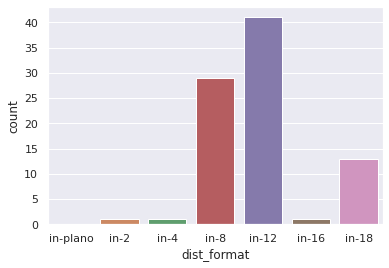

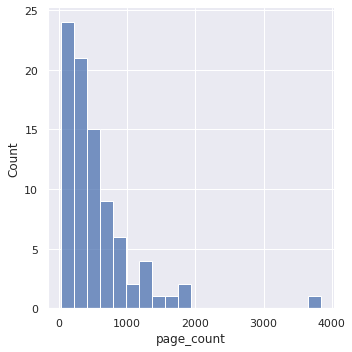

In [92]:
# Have a look at ./utils.py if you are interested in the implementation details.
from utils import parse_distribution_format
from utils import parse_page_count

# Note: parse_page_count() ignores page numbers given in roman numerals by default.
# To include them in the sum, call parse_page_count() with `count_preface=True`.
# For more info about these functions use help():
#help(parse_page_count)
#help(parse_distribution_count)
# Adjust as needed:
INCLUDE_PREFACE = False

bgrf['page_count'] = pd.Series(
    data=[sum(parse_page_count(entry['page_count']['value'], count_preface=INCLUDE_PREFACE))
         for entry in results],
    index=[entry['item']['value'] for entry in results],
    dtype='Int64'
)
bgrf['dist_format'] = pd.Series(
    data=[parse_distribution_format(entry['page_format']['value'])
         for entry in results],
    index=[entry['item']['value'] for entry in results],
)
print('"page_count" column:\n', bgrf['page_count'].head(2))
print('"dist_format" column:\n', bgrf['dist_format'].head(2))
sns.countplot(x=bgrf['dist_format'], order=['in-plano', 'in-2', 'in-4', 'in-8', 'in-12', 'in-16', 'in-18'])
plt.show()
sns.displot(x=bgrf['page_count'])
plt.show()

In order to estimate the cummulative page area of each text, we need to choose any of the corventions listed at the start of this section.

In [113]:
page_areas = {
    format: area
    for format, area
    in zip(['in-plano', 'in-2', 'in-4', 'in-8', 'in-12', 'in-16', 'in-18'], areas['jesus'])
}
pprint(page_areas)
bgrf['page_area'] = bgrf['dist_format'].apply(lambda f: page_areas[f])

{'in-12': 207,
 'in-16': 239.75,
 'in-18': 212.28,
 'in-2': 1890,
 'in-4': 945,
 'in-8': 486,
 'in-plano': 3780}


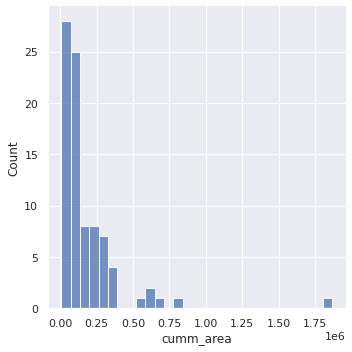

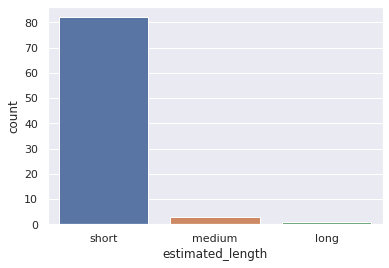

The only work categorized as "long" is actually a collection of novels:
 http://zora.uni-trier.de:53000/entity/Q135    long
Name: estimated_length, dtype: category
Categories (3, object): ['short' < 'medium' < 'long']


In [120]:
# Calculate an estimated 'cummulative page area' for each work.
bgrf['cumm_area'] = bgrf['page_area'] * bgrf['page_count']
sns.displot(x=bgrf['cumm_area'])
plt.show()
bgrf['estimated_length'] = pd.cut(bgrf['cumm_area'], bins=3, labels=['short', 'medium', 'long'])
sns.countplot(x=bgrf['estimated_length'])
plt.show()

# There is only one work described as 'long' by this procedure:
only_long = bgrf['estimated_length'][bgrf['estimated_length'] == 'long']
print('The only work categorized as "long" is actually a collection of novels:\n', only_long)

The only work which is categorized as long by this procedure is actually a collection of novels. This probably means that our binning is rather meaningless. Domain-specific knowledge would be necessary to choose adequate limits for the three bins.

### Publication Date (BGRF)

The new data Series looks like this:
 http://zora.uni-trier.de:53000/entity/Q27   1800-01-01
http://zora.uni-trier.de:53000/entity/Q28   1751-01-01
http://zora.uni-trier.de:53000/entity/Q30   1752-01-01
Name: pubyear, dtype: datetime64[ns]


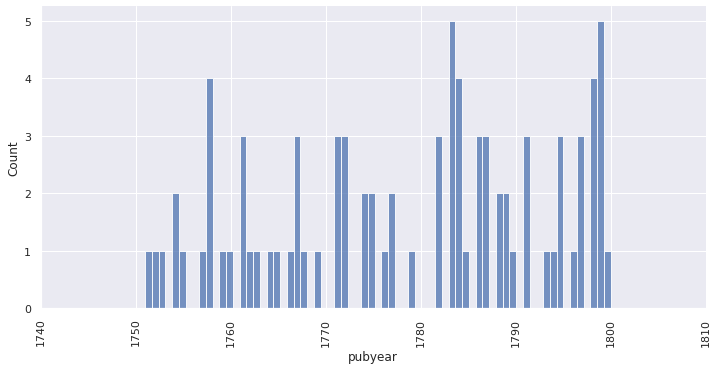

In [28]:
# Publication date
import datetime as dt

query = ''.join([
    'SELECT ?item ?pubdate ',
    'WHERE { ?item wdt:',
    ITEM_IDS['publication_date'],
    ' ?pubdate. }'
])
pubdate = get_data(wb_endpoint, query)

bgrf['pubyear'] = pd.Series(
    data=[dt.date.fromisoformat(entry['pubdate']['value'].split('T')[0]) for entry in pubdate],
    index=[entry['item']['value'] for entry in pubdate],
    dtype='datetime64[ns]'
)

print('The new data Series looks like this:\n', bgrf['pubyear'].head(3))

year_range = bgrf['pubyear'].max().year - bgrf['pubyear'].min().year
plot = sns.displot(x=bgrf['pubyear'], bins=time_range, height=5, aspect=16/8)
plot.set_xticklabels(rotation=90)

### Narrative Form (BGRF)

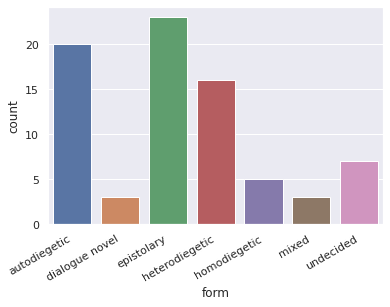

In [29]:
# Narrative form
query = ''.join([
    'SELECT ?item ?form ',
    'WHERE { ?item wdt:',
    ITEM_IDS['narrative_form_str'],
    ' ?form. }'
])
form = get_data(wb_endpoint, query)
form = pd.Series(
    data=[entry['form']['value'] for entry in form],
    index=[entry['item']['value'] for entry in form],
    dtype='category'
)
# This is brutish, but I do not want to write some elaborate
# regexes for something which is essentially still undecided as far
# as the adequate modelling goes.
mapping = {
    'Dialogues': 'dialogue novel',
    'Deux récits 1re personne': 'undecided',
    'Ire personne virant à la 3e, avec dialogues': 'undecided',
    'Ire personne (mémoires découpés en lettres)': 'undecided',
    'Saillard Tchemerzine 3e personne': 'heterodiegetic',
    '3e personne, avec récit intercalé 1re personne': 'undecided',
    '1re personne, avec récits intercalés 1re personne': 'autodiegetic',
    '3e personne, avec dialogues, récits intercalés 1re personne, intervention du narrateur': 'undecided',
    '3e partie: Relation du voyage d’un sublunaire; 1re personne avec des récits d’autres voyageurs': 'undecided',
    '1re personne (mémoires)': 'autodiegetic',
    '1re personne (mémoires), avec récit intercalé 1re personne': 'autodiegetic',
    '1re personne, songe': 'autodiegetic',
    'Lettres, avec récits intercalés 1re personne': 'epistolary',
    'Lettres': 'epistolary',
    'Saint-Fargeau Lettres': 'epistolary',
    '3e personne, avec récits intercalés 1re personne et lettres': 'mixed',
    'Dialogue, avec récits racontés par les personnages': 'dialogue novel',
    '3e personne': 'heterodiegetic',
    '3e personne, avec récit de Jezennemours à la 1re personne': 'homodiegetic',
    '3e personne avec des observations 1re personne': 'homodiegetic',
    'Lettres, interrompues par un récit (I, 83 - 160)': 'mixed',
    '1re personne': 'autodiegetic',
    'Lettres, avec deux histoires intercalées': 'mixed',
    'Cadre 1re personne avec récit 1re personne': 'autodiegetic',
    '3e personne, avec contes intercalés 3e personne (I, 43, Le plaisir, conte moral; II, 10, Aventure du pèlerin)': 'homodiegetic',
    '3e personne, interrompu par des conversations': 'homodiegetic',
    'Ire personne': 'autodiegetic',
    '3e personne, avec récits intercalés 1re personne': 'homodiegetic',
}
#print('\n'.join([i for i in set(bgrf['form'].values) ]))
bgrf['form'] = form.replace(mapping).astype('category')
plot = sns.countplot(x=bgrf['form'])
_ = plt.xticks(rotation=30, horizontalalignment='right')

## Comparison

### Publication Date (Corpus vs BGRF)

In [30]:
# Publication year of corpus texts:
year_corpus = (corpus['firsted-yr']
    .astype('|S')
    .replace('(\d{4})-\d{4}', '\1', regex=True)
    .str.decode('utf-8'))
year_corpus = pd.to_datetime(year_corpus, errors='coerce')

# Publication year of BGRF items:
year_bgrf = bgrf['pubyear']

# Create a date index which includes the whole data range
# so that we can fill in missing data points.
idx = pd.date_range(start='1730', end='1800', freq='YS', closed=None)

# In previous visualizations we have used absolute value counts.
# For comparison we obviously need to use relative frequencies instead.
df = pd.DataFrame(index=idx)
df['freq_corpus'] = year_corpus.value_counts(normalize=True)
df['freq_bgrf'] = year_bgrf.value_counts(normalize=True)
df['year'] = df.index.year
print('The data in "wide form"\n', df.head(4), '\n')

# For the visualization we need the data in "long form", i.e. all the
# relative frequencies are in one single column, with another column 
# specifying whether it stems from the corpus or the bibliography.
long = pd.melt(
    df, id_vars=['year'], value_vars=['freq_corpus', 'freq_bgrf'],
    var_name='origin', value_name='rel_freq')

print('The data in "long form"\n', long.head(4))

The data in "wide form"
             freq_corpus  freq_bgrf  year
1730-01-01          NaN        NaN  1730
1731-01-01     0.009174        NaN  1731
1732-01-01          NaN        NaN  1732
1733-01-01          NaN        NaN  1733 

The data in "long form"
    year       origin  rel_freq
0  1730  freq_corpus       NaN
1  1731  freq_corpus  0.009174
2  1732  freq_corpus       NaN
3  1733  freq_corpus       NaN


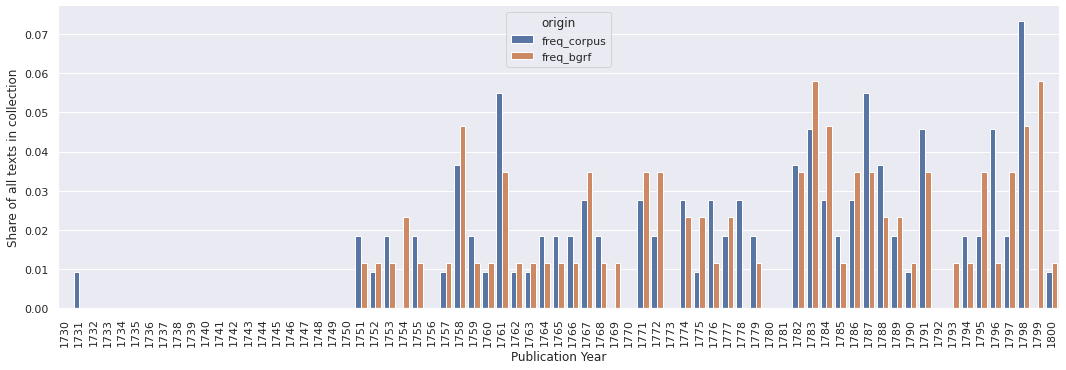

In [31]:
sns.catplot(x='year', y='rel_freq', hue='origin', kind='bar', data=long, height=5, aspect=3, legend_out=False)
plt.xlabel('Publication Year')
plt.ylabel('Share of all texts in collection')
_ = plt.xticks(rotation=90)

The outlier with publication year 1731 makes the above chart a bit harder to read than necessary. So let's create the same graph with data starting at 1751.

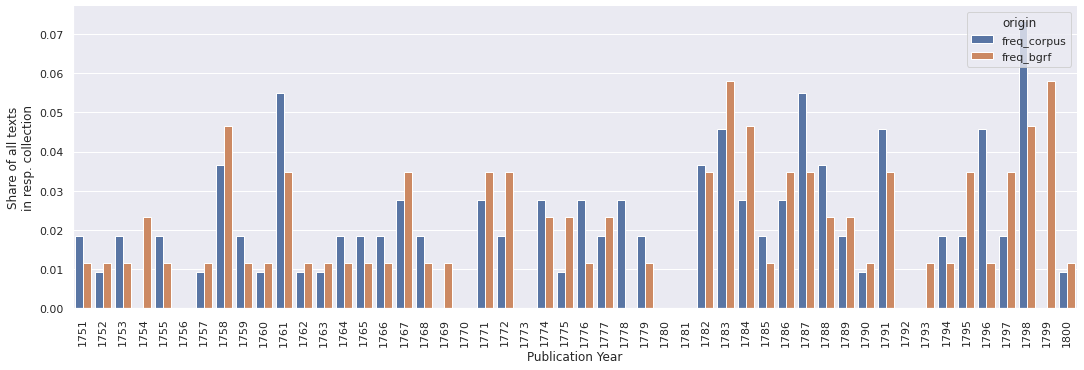

In [32]:
sns.catplot(x='year', y='rel_freq', hue='origin', kind='bar', data=long[long['year'] > 1750], height=5, aspect=3,
           legend_out=False)
plt.xlabel('Publication Year')
plt.ylabel('Share of all texts\nin resp. collection')
_ = plt.xticks(rotation=90)